In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from collections import Counter
import skimage
from skimage import io
from PIL import Image
import os
import numpy as np
from typing import Callable
from skimage.color import rgb2hsv
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

In [2]:
class CoinDataset(Dataset):
    def __init__(self):
        self.labels = pd.read_csv("dataset/train_labels.csv")
        self.root = "dataset/train/"

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
    
        img_name = os.path.join(self.root, self.labels.iloc[index, 0]+ ".JPG")
        image = io.imread(img_name)
        coins = torch.tensor(self.labels.iloc[index, 1:])
        
        sample = {'image': image, 'coins': coins}
        
        sample = self.transform(sample)
        
        return sample
    
    def transform(self, sample):
        image_og = sample['image'] 

        scale_percent = 50
        width = int(image_og.shape[1] * scale_percent / 100)
        height = int(image_og.shape[0] * scale_percent / 100)
        dim = (width, height)
        image_red = cv2.resize(image_og, dim, interpolation=cv2.INTER_AREA)
        # image_blurred = cv2.medianBlur(image_red, 19)

        return {'image':image_red, 'coins': sample['coins']}
        

def show_image(image, coins):
    plt.imshow(image.squeeze(0))
    plt.pause(0.001)
    
def show_image_batch(coin_batch):
    images_batch = coin_batch['image']
    coins_batch = coin_batch['coins']
    print(len(images_batch))
    
    for i in range(len(images_batch)):
        ax = plt.subplot(1,4, i+1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        show_image(images_batch[i], coins_batch[i])
    

In [3]:
coin_dataset = CoinDataset()
coin_dataloader = DataLoader(coin_dataset, batch_size=4, shuffle=True, num_workers=0)


OG dimensions:  (4000, 6000, 3)
reduced dimensions:  (2000, 3000, 3)


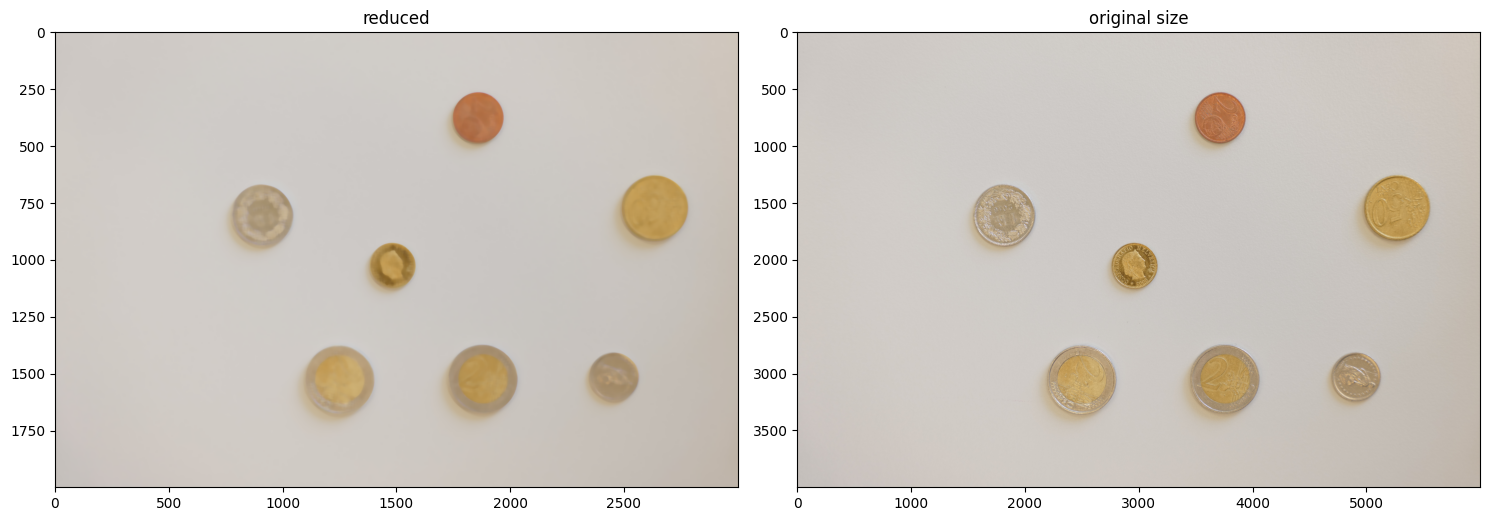

In [4]:
# Define path
path_hand = os.path.join("dataset", "train", "L1010517.JPG") #L1010378.JPG")
path_noisy = os.path.join("dataset", "train", "L1010503.JPG")#"L1010370.JPG")
path_neutral = os.path.join("dataset", "train", "L1010310.JPG")#"L1010308.JPG")#"L1010281.JPG") #"L1010422.JPG") #"L1010321.JPG")#"L1010422.JPG") #"L1010434.JPG") #"L1010283.JPG") #"L1010277.JPG")

# Check if folder and image exist
assert os.path.exists(path_hand), "Image not found, please check directory structure"

# Load image
image_hand = np.array(Image.open(path_hand))
image_noisy = np.array(Image.open(path_noisy))
image_neutral = np.array(Image.open(path_neutral))

image_og = image_neutral

scale_percent = 50
width = int(image_og.shape[1] * scale_percent / 100)
height = int(image_og.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image_og, dim, interpolation=cv2.INTER_AREA)
image = cv2.medianBlur(image, 19)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("reduced")
plt.subplot(1,2,2)
plt.title("original size")
plt.imshow(image_og)

# plt.axis('off')
plt.tight_layout()
print("OG dimensions: ", image_og.shape)
print("reduced dimensions: ", image.shape)



In [5]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    data_red = img[:,:,0]
    data_green = img[:,:,1]
    data_blue = img[:,:,2]
    # ------------------
    
    return data_red, data_green, data_blue

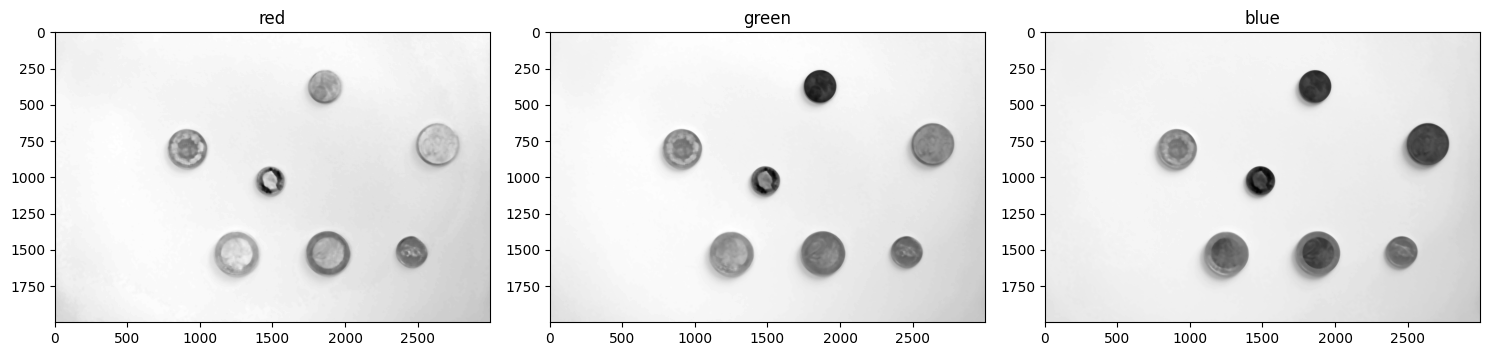

In [6]:
[data_red,data_green,data_blue] = extract_rgb_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('red')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('green')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('blue')

plt.tight_layout()

In [7]:
def apply_rgb_threshold(img):
    """
    Apply threshold to RGB input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    # data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    thr_blue = 154 # #154    #   Threshold on blue
    
    mask_blue = img[:,:,2] > thr_blue
    mask_green = img[:,:,1] > 163 #   Mask computed on red channel

    img_th = np.logical_not(mask_green)
    # ------------------

    return  img_th

def apply_rgb_threshold_hand(img):
    """
    Apply threshold to RGB input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    # data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    thr_red = 200      #   Threshold on red
    thr_green = 170 #175      #   Threshold on green
    thr_blue = 75   #   Threshold on blue
    
    mask_red = img[:,:,0] > thr_red     #   Mask computed on red channel
    mask_green = img[:,:,1] > thr_green     #   Mask computed on red channel
    mask_blue = img[:,:,2] > thr_blue       #   Mask computed on red channel

    # img_th = img_red*img_green*img_blue     #   Combine masks for all channels
    img_th = np.logical_not(mask_red*mask_green*mask_blue)
    # img_th = np.logical_or(mask_green, np.logical_not(mask_blue))
    img_th = mask_green#*mask_blue
    # ------------------

    return  img_th

<Figure size 640x480 with 0 Axes>

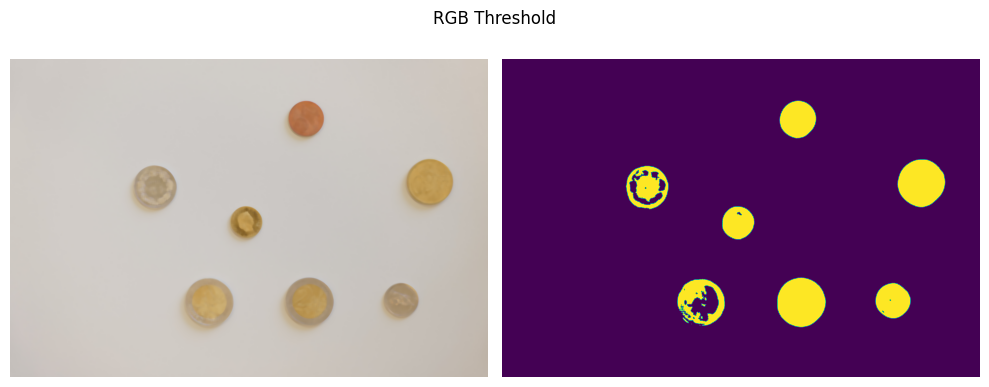

In [8]:
# Plot color space distribution 
def plot_thresholded_image(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[1].imshow(func(img))
    [a.axis('off') for a in axes]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
# Plot best RGB thresholding
plot_thresholded_image(img=image, func=apply_rgb_threshold, title="RGB Threshold")

In [9]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    hsv_img = rgb2hsv(img)
    data_h = hsv_img[:,:,0]
    data_s = hsv_img[:,:,1]
    data_v = hsv_img[:,:,2]
    # ------------------
    
    return data_h, data_s, data_v

Text(0.5, 1.0, 'value')

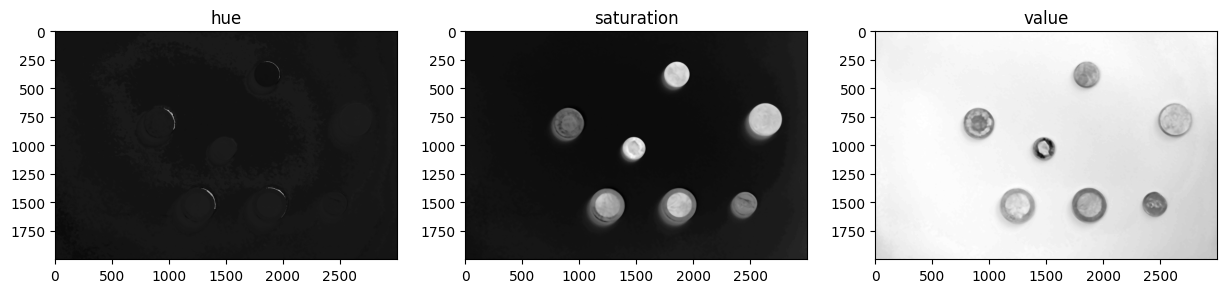

In [10]:
[data_h,data_s,data_v] = extract_hsv_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_h, cmap='gray')
plt.title('hue')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_s, cmap='gray')
plt.title('saturation')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_v, cmap='gray')
plt.title('value')


1407


<Figure size 640x480 with 0 Axes>

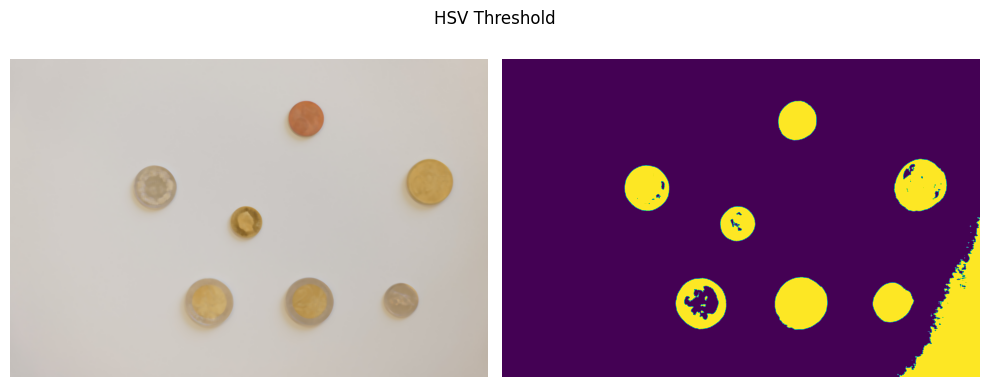

In [11]:
def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    # thr_hue_l = 0.77    #   Lower threshold on hue
    # thr_hue_u = 0.88    #   Upper threshold on hue
    
    # mask_h_l = data_h[:,:] > thr_hue_l      #   Mask computed on hue lower threshold
    # img_h_l = (mask_h_l)
    # mask_h_u = data_h[:,:] < thr_hue_u      #   Mask computed on hue upper threshold
    # img_h_u = (mask_h_u)
    # combined_hue = img_h_l * img_h_u        #   Mask computed on hue 

    # thr_v = 0.60    #   Threshold on value
    # mask_v = data_v > thr_v         #   Mask computed on value
    # img_v = np.logical_not(mask_v)
    
    thr_s_low = 0.68
    thr_s_up = 0.98 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_s = (mask_s_low)
    
    img_th = img_s  
    mask = data_s < 0.65
    mask_2 = data_v < 0.768
    mask_3 = data_v < 0.7
    img_2 = mask_2#   Thresholded image, a combination of different thresholds results in less noise
    
    # ------------------
    print(np.sum(img_th))
    if np.sum(img_th) < 5000:
        # print("case 1")
        if np.sum(np.logical_not(img_2)) > 5000:
            # print("case 2")
            return img_2
        else:
            return mask_3
    return img_th

def apply_hsv_threshold_noisy(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    
    thr_s_low = 0.1
    thr_s_up = 0.3 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_th = (mask_s_low*mask_s_up)
    
    # ------------------

    return img_th

def apply_hsv_threshold_hand(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    
    thr_s_low = 0.51
    thr_s_up = 0.65 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_th = (mask_s_low*mask_s_up)
    
    # ------------------

    return img_th

plot_thresholded_image(img=image, func=apply_hsv_threshold, title="HSV Threshold")

In [12]:
def extract_LAB_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # ------------------
    LAB_img = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L = LAB_img[:,:,0]
    A = LAB_img[:,:,1]
    B = LAB_img[:,:,2]
    # ------------------
    
    return L, A, B

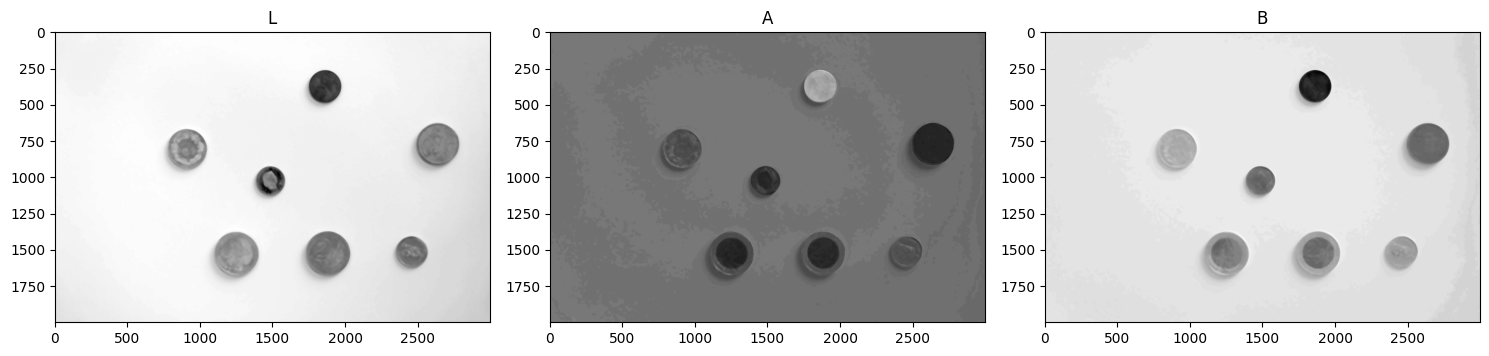

In [13]:
[data_red,data_green,data_blue] = extract_LAB_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('L')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('A')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('B')

plt.tight_layout()

In [14]:
def apply_LAB_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_A = 130      #   Threshold on green
    
    mask_A = LAB_img[:,:,1] > thr_A     #   Mask computed on red channel
    
    img_th = np.logical_not(mask_A) 
    
    # ------------------
    return  img_th

def apply_LAB_threshold_noisy(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_B = 113 #107     #   Threshold on blue
    
    mask_B = LAB_img[:,:,2] > 107  
    mask_2 = LAB_img[:,:,2] < 107#   Mask computed on red channel
    mask_3 = LAB_img[:,:,2] > 114
    mask_4 = LAB_img[:,:,2] < 117

    img_th = np.logical_or(np.logical_not(mask_B)* mask_2, mask_3*mask_4) #+ np.logical_not(mask_3)
    # ------------------
    return img_th



<Figure size 640x480 with 0 Axes>

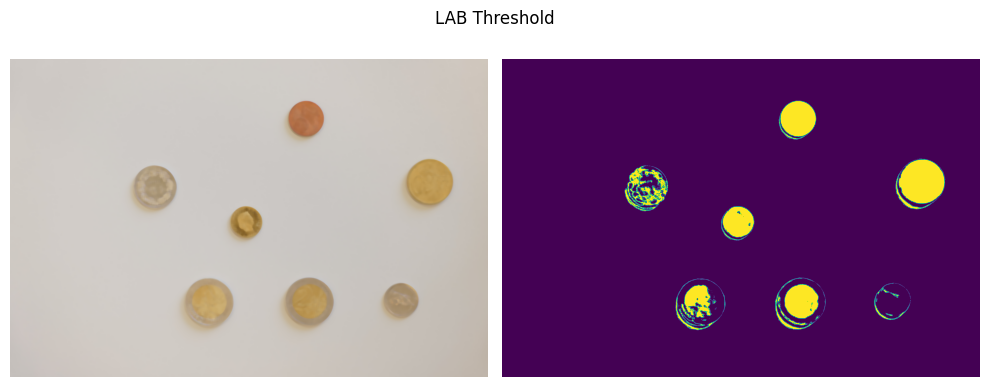

In [15]:
plot_thresholded_image(img=image, func=apply_LAB_threshold_noisy, title="LAB Threshold")

In [16]:
def apply_threshold(img):
    # image_blurred = cv2.medianBlur(img, 9)
    # image_blurred = cv2.GaussianBlur(img, (11,11), cv2.BORDER_DEFAULT) # https://stackoverflow.com/questions/70659992/how-to-improve-accuracy-of-cv2s-houghcircles
    image_blurred = cv2.medianBlur(img, 17)
    background = find_background(img)
    neutral_detected, coins = detect_neutral(img)
    hand_detected, hand = detect_hand(img)
    if neutral_detected and background[0] > 180:
        print("neutral")
        background_type = "neutral"
        img_th = np.logical_not(coins==0)
    elif hand_detected and background[0] > 180:
        background_type = "hand"
        print("hand")
        img_th = np.logical_not(np.logical_or(apply_LAB_threshold(img), apply_hsv_threshold_hand(img))) #np.logical_or(apply_rgb_threshold_hand(img), apply_hsv_threshold_hand(img)) #*(hand)
    else:
        print("noisy")
        img_th = apply_LAB_threshold_noisy(img)
        background_type = "noisy"
    # print(img_th)
    return img_th, background_type

def detect_neutral(img):
    # https://stackoverflow.com/questions/58668245/how-to-quickly-and-efficiently-check-if-an-image-is-mostly-background
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100
    return ratio < 10, thresh

def detect_hand(img):
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100    
    return (ratio < 30), thresh

def find_background(img):
    # https://umarmasud07.medium.com/easiest-approach-for-background-colour-detection-5914217da325
    blue,green,red=cv2.split(img)
    blue=blue.flatten()
    green=green.flatten()
    red=red.flatten()
    blue_counter=Counter(blue)
    green_counter=Counter(green)
    red_counter=Counter(red)
    blue_most=blue_counter.most_common(10)
    blue_avg=[i for i,j in blue_most]
    blue_avg=int(np.mean(blue_avg))
 
    green_most=green_counter.most_common(10)
    green_avg=[i for i,j in green_most]
    green_avg=int(np.mean(green_avg))
    red_most=red_counter.most_common(10)
    red_avg=[i for i,j in red_most]
    red_avg=int(np.mean(red_avg))
    background=[blue_avg,green_avg,red_avg]
    return(background)


In [17]:
# plot_thresholded_image(img=image, func=apply_threshold, title="Combined Threshold")

In [18]:
# import random
# list = random.sample(range(0,80),5)
# print(list)
# list = [3, 4, 56,31, 32, 66, 77]
# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     plot_thresholded_image(img=coin_dataset[i]['image'], func=apply_threshold, title="Combined Threshold")

In [19]:
def apply_morphology(img_th):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img_th)
    
    # ------------------
    img_obj = skimage.morphology.remove_small_objects(img_th, min_size=100, connectivity=1, out=None)
    img_morph = skimage.morphology.remove_small_holes(img_obj, area_threshold=20, connectivity=1, out=None)
    # ------------------
    
    return img_morph

In [20]:
def apply_processing(img):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img)
    
    # ------------------
    img_thr, background_type = apply_threshold(img)
    # img_morph = apply_morphology(img_thr)
    # ------------------
    
    return img_thr, background_type

In [21]:
# import random
# list = random.sample(range(0,80),5)
# print(list)
# # list = [66, 29]
# list = [25, 29, 31, 32, 38, 77, 78, 79]

# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     img_th = apply_threshold(img=coin_dataset[i]['image'])
#     plot_thresholded_image(img=img_th, func=apply_morphology, title="Combined Threshold")

In [22]:
def edge_detection(img):
    cleaned = (img.astype(np.uint8))*255

    edged = cv2.Canny(cleaned,210,500)
    return edged

def apply_detection(img):
    img_processed = apply_processing(img)
    return edge_detection(img_processed)

In [23]:
# import random
# list = random.sample(range(0,80),5)
# print(list)

# for i in list:
#     print(i, coin_dataset.labels.iloc[i, 0])
#     plot_thresholded_image(img=coin_dataset[i]['image'], func=apply_detection, title="Combined Threshold")

In [24]:
def hough_tranform(edge):
    cleaned = (edge.astype(np.uint8))*255
# img = cleaned
    img = cv2.medianBlur(cleaned, 11)

# img = cv.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT_ALT,1,10, param1=100,param2=0.3,minRadius=50,maxRadius=200)
    circles = circles[0]
    return circles


In [25]:
# img = (apply_processing(image_og)).astype(np.uint8)*255
# # processed = apply_processing(image_og)
# # img = image_og * [processed, processed, processed]


In [26]:


# # img = cv.medianBlur(img,5)
# cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

# # hist = cv2.equalizeHist(cimg)

# blur = cv2.GaussianBlur(img, (31,31), cv2.BORDER_DEFAULT) # https://stackoverflow.com/questions/70659992/how-to-improve-accuracy-of-cv2s-houghcircles

# circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT_ALT,1.6,minDist=150, param1=300,param2=0.55, minRadius=175,maxRadius=800)
# print(circles)
# circles = circles[0]

# fig, ax = plt.subplots()

# ax.imshow(img)

# circles = np.uint16(np.around(circles))
# print("circles: ", circles)

# for i in circles:
#     # draw the outer circle
#     plt.scatter(i[0],i[1])
#     # draw the center of the circle
#     circle_obj = plt.Circle((i[0], i[1]), radius=i[2] , fill=False, color='r')
#     ax.add_patch(circle_obj)

In [27]:
def get_circles(img):
    
    blur = cv2.GaussianBlur(img, (35,35), cv2.BORDER_DEFAULT) # https://stackoverflow.com/questions/70659992/how-to-improve-accuracy-of-cv2s-houghcircles

    circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT_ALT,1.5,minDist=110, param1=220,param2=0.6, minRadius=75,maxRadius=500)
    print(circles)
    circles = circles[0]
    
    return circles

def segment(img):
    img_processed, background_type = apply_processing(img)
    img_processed= img_processed.astype(np.uint8)*255
    circles = get_circles(img_processed)
    circles = np.uint16(np.around(circles))
    result = []
    for i in range(0, len(circles)):
        add = True
        for j in range(0, len(result)):
            if circles[i][0] == result[j][0] and result[j][1] == circles[i][1]:
                add = False
                if circles[i][2] > result[j][2]:
                    result[j][2] = circles[i][2]
        if add:
            result.append(circles[i])
    return img_processed, result

def crop_image_into_patches(image, circles): #, background_type):
    patches = []
    for i in range(len(circles)):
        current_circle = circles[i]
        current_x = current_circle[0]
        current_y = current_circle[1]
        current_r = current_circle[2]

        # cropped = image[(current_x - current_r) : (current_x + current_r) , (current_y - current_r) : (current_y + current_r) ]

        # Calculate bounding box coordinates for cropping
        top_left_x = max(0, current_x - current_r)
        top_left_y = max(0, current_y - current_r)
        bottom_right_x = min(image.shape[1], current_x + current_r)
        bottom_right_y = min(image.shape[0], current_y + current_r)

        # Crop circular region
        cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        # if not (np.sum(cropped) > 1500 and background_type == "hand"):
        patches.append(cropped)
            
    return patches

def plot_coins(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """
    plt.figure()
    # fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # axes[0].imshow(img)
    # axes[1].imshow(func(img))
    # [a.axis('off') for a in axes]
    # plt.suptitle(title)
    # plt.tight_layout()
    # plt.show()
    print(img.shape)
    processed, circles = func(img)
    fig, ax = plt.subplots()

    ax.imshow(img)

    print("circles: ", circles)

    for i in circles:
        # draw the outer circle
        plt.scatter(i[0],i[1])
        # draw the center of the circle
        circle_obj = plt.Circle((i[0], i[1]), radius=i[2] , fill=False, color='r')
        ax.add_patch(circle_obj)
    plt.tight_layout()
    plt.show()

    return circles
    
# plot_coins(img=image_og, func=segment, title="Combined Threshold")

[50, 57, 33, 58, 11, 47, 31, 23, 54, 61]
0 L1010281
(2000, 3000, 3)
neutral
[[[ 681.       1146.        127.07124 ]
  [1263.       1246.5       114.49728 ]
  [1501.5      1234.5       102.7453  ]
  [1779.        895.5       108.441574]
  [ 727.5       609.        127.558784]
  [ 727.5       609.        113.62422 ]
  [ 838.5      1518.        120.8754  ]
  [1462.5       531.        104.864784]
  [1095.        804.        127.26452 ]
  [1501.5      1234.5       115.84932 ]
  [1263.       1246.5       100.95188 ]
  [1779.        895.5       121.768   ]]]
circles:  [array([ 681, 1146,  127], dtype=uint16), array([1263, 1246,  114], dtype=uint16), array([1502, 1234,  116], dtype=uint16), array([1779,  896,  122], dtype=uint16), array([728, 609, 128], dtype=uint16), array([ 838, 1518,  121], dtype=uint16), array([1462,  531,  105], dtype=uint16), array([1095,  804,  127], dtype=uint16)]


<Figure size 640x480 with 0 Axes>

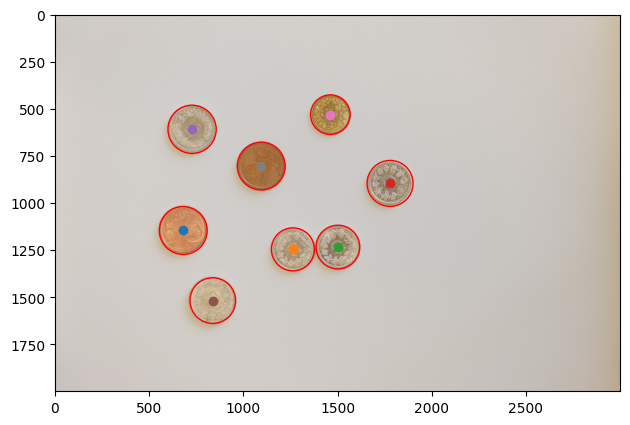

circles:  [array([ 681, 1146,  127], dtype=uint16), array([1263, 1246,  114], dtype=uint16), array([1502, 1234,  116], dtype=uint16), array([1779,  896,  122], dtype=uint16), array([728, 609, 128], dtype=uint16), array([ 838, 1518,  121], dtype=uint16), array([1462,  531,  105], dtype=uint16), array([1095,  804,  127], dtype=uint16)]
1 L1010298
(2000, 3000, 3)
neutral
[[[1189.5      1239.        159.36766 ]
  [1335.        750.        160.27034 ]
  [1579.5      1603.5       140.36978 ]
  [1881.       1153.5       107.145485]
  [1813.5       738.        107.144745]
  [1579.5      1603.5       121.318924]
  [1335.        750.        144.24435 ]]]
circles:  [array([1190, 1239,  159], dtype=uint16), array([1335,  750,  160], dtype=uint16), array([1580, 1604,  140], dtype=uint16), array([1881, 1154,  107], dtype=uint16), array([1814,  738,  107], dtype=uint16)]


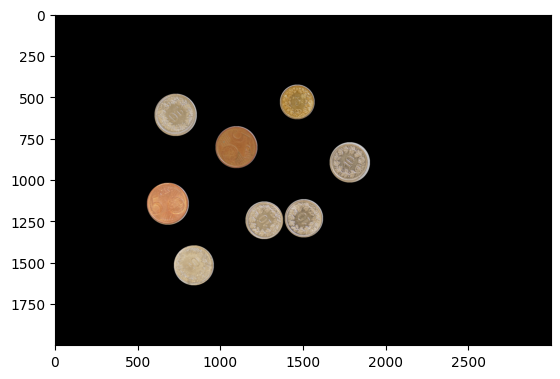

<Figure size 640x480 with 0 Axes>

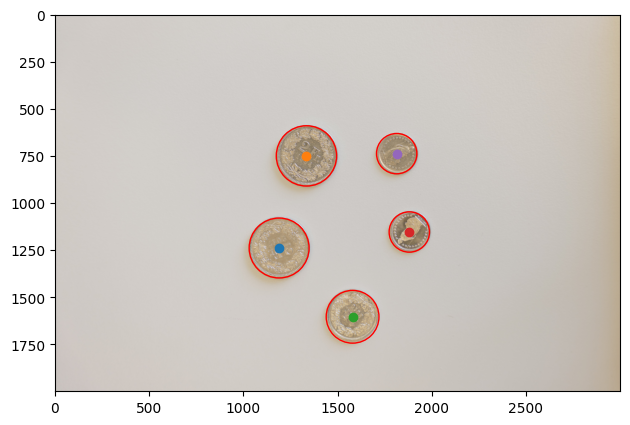

circles:  [array([1190, 1239,  159], dtype=uint16), array([1335,  750,  160], dtype=uint16), array([1580, 1604,  140], dtype=uint16), array([1881, 1154,  107], dtype=uint16), array([1814,  738,  107], dtype=uint16)]
2 L1010321
(2000, 3000, 3)
neutral
[[[ 549.        868.5       138.03955 ]
  [1330.5       472.5       135.88603 ]
  [1452.       1624.5       108.881035]
  [ 784.5      1323.         95.3448  ]
  [1801.5       735.        129.25697 ]
  [1122.       1338.        129.30554 ]
  [ 784.5      1323.        108.88644 ]
  [2643.        814.5       157.56958 ]
  [2076.       1435.5       134.32922 ]
  [2643.       1657.5       123.41231 ]]]
circles:  [array([549, 868, 138], dtype=uint16), array([1330,  472,  136], dtype=uint16), array([1452, 1624,  109], dtype=uint16), array([ 784, 1323,  109], dtype=uint16), array([1802,  735,  129], dtype=uint16), array([1122, 1338,  129], dtype=uint16), array([2643,  814,  158], dtype=uint16), array([2076, 1436,  134], dtype=uint16), array([2643

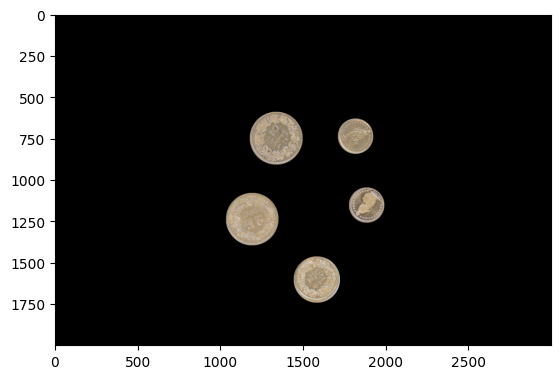

<Figure size 640x480 with 0 Axes>

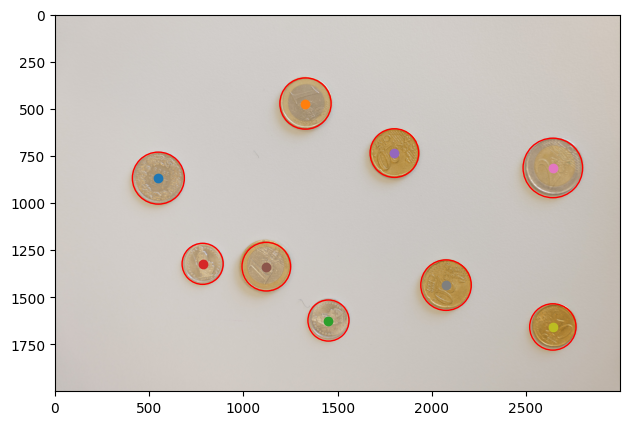

circles:  [array([549, 868, 138], dtype=uint16), array([1330,  472,  136], dtype=uint16), array([1452, 1624,  109], dtype=uint16), array([ 784, 1323,  109], dtype=uint16), array([1802,  735,  129], dtype=uint16), array([1122, 1338,  129], dtype=uint16), array([2643,  814,  158], dtype=uint16), array([2076, 1436,  134], dtype=uint16), array([2643, 1658,  123], dtype=uint16)]
3 L1010310
(2000, 3000, 3)
neutral
[[[1249.5     1530.       149.6019 ]
  [1881.      1528.5      154.9161 ]
  [ 909.       808.5      136.55553]
  [ 909.       808.5      119.11424]
  [1482.      1030.5      103.11245]
  [2452.5     1519.5      113.40363]
  [2634.       777.       146.11966]
  [1858.5      379.5      112.52297]]]
circles:  [array([1250, 1530,  150], dtype=uint16), array([1881, 1528,  155], dtype=uint16), array([909, 808, 137], dtype=uint16), array([1482, 1030,  103], dtype=uint16), array([2452, 1520,  113], dtype=uint16), array([2634,  777,  146], dtype=uint16), array([1858,  380,  113], dtype=uint

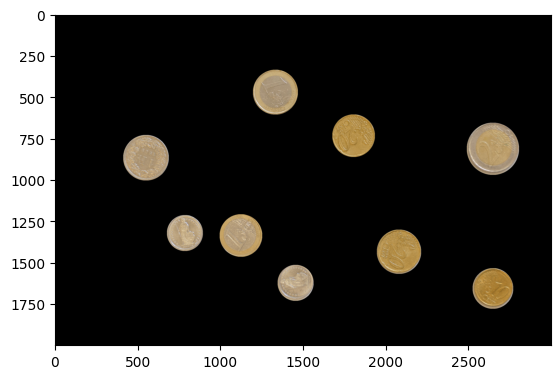

<Figure size 640x480 with 0 Axes>

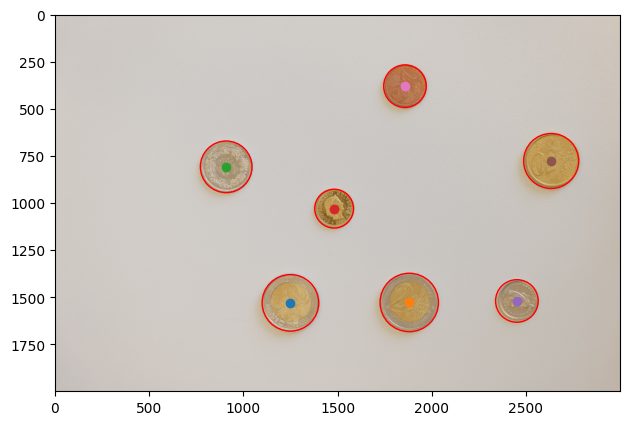

circles:  [array([1250, 1530,  150], dtype=uint16), array([1881, 1528,  155], dtype=uint16), array([909, 808, 137], dtype=uint16), array([1482, 1030,  103], dtype=uint16), array([2452, 1520,  113], dtype=uint16), array([2634,  777,  146], dtype=uint16), array([1858,  380,  113], dtype=uint16)]
4 L1010300
(2000, 3000, 3)


KeyboardInterrupt: 

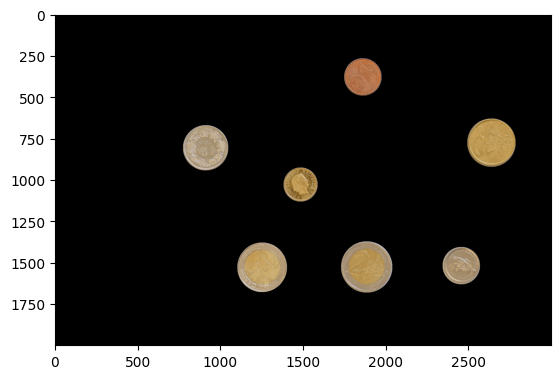

<Figure size 640x480 with 0 Axes>

In [28]:
import random
list = random.sample(range(0,80),10)
print(list)
list = [25, 29, 31, 32, 38, 77, 78, 79]
# list=[0,1]
for i in range(0,5):
    print(i, coin_dataset.labels.iloc[i, 0])
    circles = plot_coins(img=coin_dataset[i]['image'], func=segment, title="Coins")
    print("circles: ", circles)

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for j in range(len(circles)):
        current_circle = circles[j]
        rr, cc = skimage.draw.disk(current_circle[0:2][::-1], current_circle[2], shape=image.shape[:2])
        mask[rr, cc] = 1

    mask_3d = np.stack([mask] * 3, axis=-1)
    masked_image = mask_3d * coin_dataset[i]['image']
    plt.imshow(masked_image)

    patches = crop_image_into_patches(masked_image, circles = circles)
    # for p in range(len(patches)):                                     # saving the cropped images
    #     cv2.imwrite(f'cropped_{i}_{p}.jpg', cv2.cvtColor(patches[p], cv2.COLOR_RGB2BGR))    


In [ ]:
coin_dataset[1]['coins']

tensor([0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])